# Metric Analysis for ECON model

In [1]:
%reload_ext autoreload
%autoreload 2

# from common.metrics.gradient import Gradient
import torch
import torchinfo
import numpy as np
import pytorch_lightning as pl 
import matplotlib.pyplot as plt
import ast
import os
import sys

# import modules from ECON model
module_path = os.path.abspath(os.path.join('../../workspace/models/econ/code/')) # or the path to your source code
sys.path.insert(0, module_path)
from q_autoencoder import AutoEncoder
from autoencoder_datamodule import AutoEncoderDataModule

# import modules from common metrics
module_path = os.path.abspath(os.path.join('../../workspace/common/metrics/')) # or the path to your source code
sys.path.insert(0, module_path)
from gradient import Gradient
from hessian import Hessian
from CKA import CKA
from neural_efficiency import NeuralEfficiency





/opt/conda/envs/loss_landscape/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Select the desired ECON model:

In [2]:
base_path = "/home/jovyan/checkpoint/"
batch_size = 1024
learning_rate = 0.0015625
precision = 8
size = 'small'

In [3]:
def load_model(path, batch_size, learning_rate, precision, size):
    model_path = path + f'bs{batch_size}_lr{learning_rate}/ECON_{precision}b/{size}/net_1_best.pkl'
    
    # load the model
    model = AutoEncoder(
        quantize=(precision < 32),
        precision=[
            precision,
            precision,
            precision+3
        ],
        learning_rate=learning_rate,
        econ_type=size
    )
    
    # to set the map location
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model(torch.randn((1, 1, 8, 8)))  # Update tensor shapes 
    model_param = torch.load(model_path, map_location=device)
    model.load_state_dict(model_param['state_dict'])
    
    return model


# model = load_model(base_path, batch_size, learning_rate, precision, size)
# torchinfo.summary(model, input_size=(1, 1, 8, 8))  # (B, C, H, W)     

Setup the data loader:

In [4]:
data_path = '../../data/ECON/Elegun'
processed_file = 'nELinks5.npy'

def get_data_module(batch_size):
    data_module = AutoEncoderDataModule(
        data_dir=data_path,
        data_file=os.path.join(data_path, processed_file),
        batch_size=batch_size,
        num_workers=4
        )
    # checek if we have processed the data
    if not os.path.exists(os.path.join(data_path, processed_file)):
        print('Processing the data...')
        data_module.process_data(save=True)

    data_module.setup(0)
    return data_module

data_module = get_data_module(batch_size)

Model performances:

In [5]:
trainer = pl.Trainer(
        max_epochs=5,
        accelerator="auto",
        devices=1
    )

def compute_EMD(bs, lr, size, precision, load=True):
    if load:
        print("Loading the EMD...")
        emd_path = base_path + f'bs{bs}_lr{lr}/ECON_{precision}b/{size}/{size}_emd_1.txt'
        # load the achieved EMD of the model
        emd = None
        try:
            emd_file = open(emd_path)
            emd_text = emd_file.read()
            emd = ast.literal_eval(emd_text)
            emd = emd[0]['AVG_EMD']
            emd_file.close()
            return emd
        except Exception as e:
            print("ATTENTION: not able to open the file with the EMD content!")
        
    print("Computing the EMD...")
    # load the model 
    model = load_model(base_path, bs, lr, precision, size)
    # get the data loader
    data_module = get_data_module(bs)
    _, val_sum = data_module.get_val_max_and_sum()
    model.set_val_sum(val_sum)
    data_module.setup("test")
    avg_emd = trainer.test(model, dataloaders=data_module.test_dataloader(), verbose=False)
    return avg_emd
    



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## (Estimated) Fisher trace

In [6]:
# _, val_loader = data_module.dataloaders()

# metric = Fisher(
#     model=model,
#     data_loader=val_loader,
#     optimizer=model.configure_optimizers(),
#     target_layers=['encoder.conv', 'encoder.enc_dense']
# )

# metric.compute()

## Hessian 

In [7]:

# _, val_loader = data_module.dataloaders(max_batches=100)

# print(len(val_loader))
# metric = Hessian(
#     model=model,
#     data_loader=val_loader,
#     loss=model.loss)

# results = metric.compute()
# len(results)

## CKA similarity

Extract the features from each layer of the model:

In [8]:
# model1 = load_model(base_path, 1024, 0.1, 8, 'small')
# model2 = load_model(base_path, 256, 0.003125, 2, 'small')

In [9]:
# metric = CKA(model1, layers=['encoder.conv', 'encoder.enc_dense'])

# result = metric.compare(model2, layers=['encoder.conv', 'encoder.enc_dense'])


In [10]:
# model_small = load_model(base_path, 1024, learning_rate, 8, 'small')
# data_module_small = get_data_module(1024)

# model_baseline = load_model(base_path, 1024, learning_rate, 2, 'small')
# data_module_baseline = get_data_module(1024)

# activation_layers=['encoder.relu1', 'encoder.relu2']

# metric = CKA(model_small, 
#              data_module_small.test_dataloader(),
#              activation_layers=activation_layers)

# result = metric.compare(model_baseline, 
#                         data_module_baseline.test_dataloader(), 
#                         activation_layers)


# plot_cka_heatmap(result['cka_dist'], 
#                  f"ECON BS: {batch_size} LR: {learning_rate} size: {size}\n 8 bit VS 2 bit",
#                  x_label='model 2',
#                  y_label='model 1')

## Neural Efficiency

In [11]:
model = load_model(base_path, 128, 0.003125, 8, 'small')
data_module = get_data_module(1)
# emd = compute_EMD(1024, 0.003125, 'small', 8)

FileNotFoundError: [Errno 2] No such file or directory: '/home/jovyan/checkpoint/bs128_lr0.003125/ECON_8b/small/net_1_best.pkl'

In [ ]:
metric = NeuralEfficiency(model.encoder, data_module.test_dataloader(), performance=None, max_batches=1000)
result = metric.compute(beta=-2)

result

Computing the Neural efficiency...


/home/jovyan/loss_landscape_taxonomy/workspace/common/metrics/neural_efficiency.py:112: UserWarning: Attention: the layer conv has tuple as features!
  warnings.warn(f"Attention: the layer " + name + " has tuple as features!")
/home/jovyan/loss_landscape_taxonomy/workspace/common/metrics/neural_efficiency.py:108: UserWarning: Attention: the layer conv.conv has None features!
  warnings.warn(f"Attention: the layer " + name + " has None features!")


800
100
layers neural efficiency:
 {'conv': 0.08698144271506131, 'enc_dense': 0.002597523870257269}
network neural efficiency:
 0.015031180050873815
aIQ
 None


/home/jovyan/loss_landscape_taxonomy/workspace/common/metrics/neural_efficiency.py:185: UserWarning: Warning: you cannot compute the aIQ without the performance of the model (accuracy, EMD, MSE, ...).
  warnings.warn("Warning: you cannot compute the aIQ without the performance of the model (accuracy, EMD, MSE, ...).")


{'layers_efficiency': {'conv': 0.08698144271506131,
  'enc_dense': 0.002597523870257269},
 'network_efficiency': 0.015031180050873815,
 'aIQ': None}

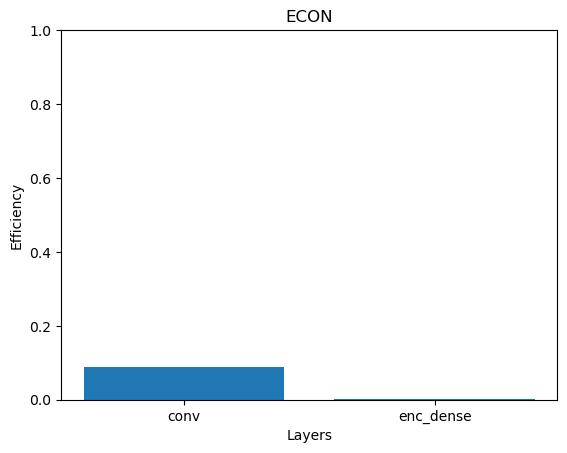

In [ ]:
def plot_neural_efficiency_per_layer(neural_efficiency_values, 
                                     title, 
                                     x_label='Layers', 
                                     y_label='Efficiency'):
    # Create a heatmap
    plt.bar(neural_efficiency_values.keys(), 
            neural_efficiency_values.values())

    plt.ylim(0, 1)
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Display the plot
    plt.show()
    

plot_neural_efficiency_per_layer(result['layers_efficiency'], 'ECON')